# REDA1-CE1003: Executive Education

## Data Analytics and Visualization



### Summer 2021 

## Week 4: An Introduction to Time Series Analysis 
### The Indepensible Tool of CRE

### Introduction

* A time series is simply the observation of a random variable $\{y_t\}$ over a sample time frame, $t=1,...,T$.  
    * Examples include any financial data, including cap rates, vacancy rates and rents.
    * Time increments could be a month, a day, a second, or something smaller if one were dealing with high-frequency trading data.



* We propose that some **Data Genereating Process** gave rise to the series that we observe.  
    * The process could be nearly continuous, as in high-frequency trading data, or discrete, as in quarterly vacancy rates.  
    * Our goal is to the model a time series in order to learn about its characteristics, either for hypothesis testing or prediction.  
    * In CRE, prediction (or forecasting) is the typical application.



### Key Topics

1. **Trends**.  Are there consistent upward or downward patterns?
2. **Serial dependence**.  Are there positive or negative correlations of time-adjacent observations?
3. **Stationarity**.  Would the series diverge to $\pm \infty$ in finite time? 

Let's look at some time series data to discuss these key topics.

In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import fix_yahoo_finance
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

import datetime as dt
from fredapi import Fred
fred = Fred(api_key='30e6ecb242a73869e11cb35f6aa3afc3')

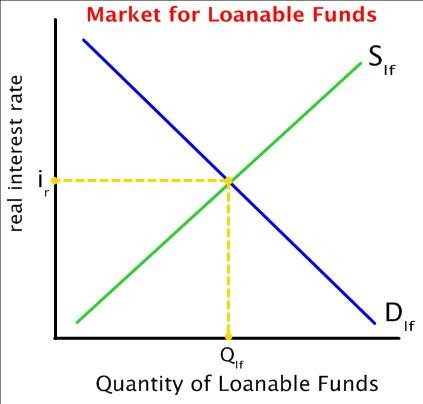

In [2]:
from IPython.display import Image
url = 'https://sbhshgovapmacro.files.wordpress.com/2011/04/loanable-funds-graph.jpg'
Image(url, width=400, height=400)

### The Price of Money: An Interest Rate
* Economists believe the prices are determined **in equilibrium** by something no economist observes: demand and supply curves.
    * The curves themselves are representations of an idea.
    * The equilibrium condition generates observations.



* An **interest rate** is simply a price of something, in this case the price of money. 



* The price of money and an interest rate are **inversely related**: higher the price, the lower the interest rate.



* We can display this in the typical demand-supply graph in economics.
    * Holding **demand fixed**, what does the supply of loanable funds imply for real interest rates?
    * Holding **supply fixed**, what does the demand for loanable funds imply for real interest rates?



* Scott Sumner: [Never reason from a price change](https://www.themoneyillusion.com/never-reason-from-a-price-change/)
    * What does this phrase mean?  
    * It is related to causality.  
    * We do not know whether the demand for loanable funds changed or the supply of loanable funds changed.  
    * We only observe changes in interest rates.   

## Storytelling with Time Series: A Staple of CRE

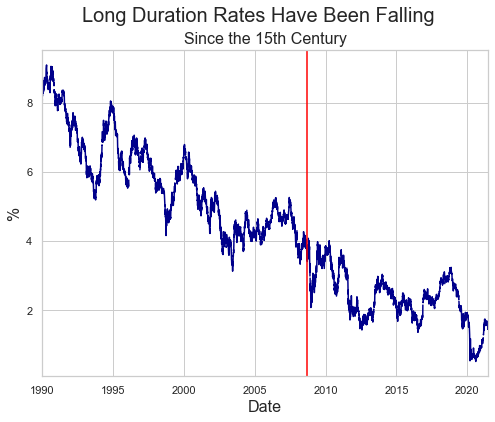

In [3]:
ten_year = fred.get_series("DGS10", observation_start='1990-01-01')
one_year = fred.get_series("DGS1", observation_start='1990-01-01')
three_month = fred.get_series("DGS3MO", observation_start='1990-01-01')

ten_year.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Long Duration Rates Have Been Falling', fontsize=20)
plt.title('Since the 15th Century', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")

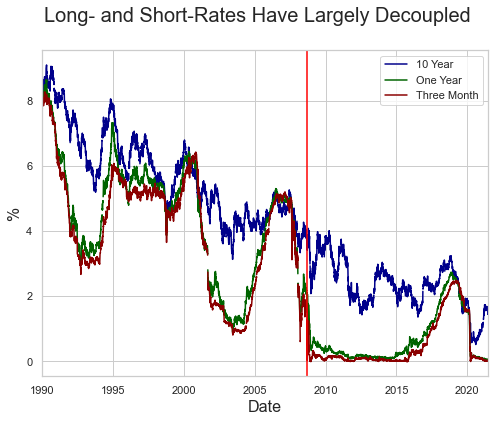

In [4]:
ten_year.plot(c='darkblue', label='10 Year', figsize=(8, 6), )
one_year.plot(c='darkgreen', label='One Year')
three_month.plot(color='darkred', label='Three Month')
plt.suptitle('Long- and Short-Rates Have Largely Decoupled', fontsize=20)
plt.legend()
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")

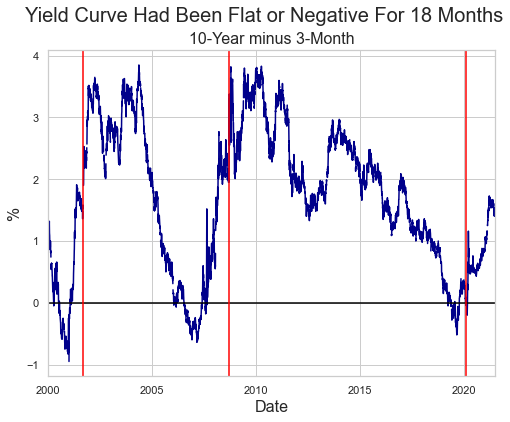

In [5]:
yield_curve = fred.get_series("T10Y3M", observation_start='2000-01-01')
yield_curve.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Yield Curve Had Been Flat or Negative For 18 Months', fontsize=20)
plt.title('10-Year minus 3-Month', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(0, color="black")
plt.axvline(dt.datetime(2001, 9, 11), color="red")
plt.axvline(dt.datetime(2008, 9, 15), color="red")
plt.axvline(dt.datetime(2020, 2, 6), color="red")

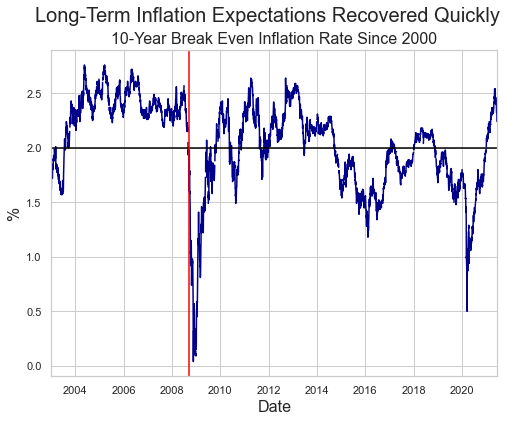

In [6]:
break_even = fred.get_series("T10YIE", observation_start='1990-01-01')
break_even.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Long-Term Inflation Expectations Recovered Quickly', fontsize=20)
plt.title('10-Year Break Even Inflation Rate Since 2000', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(2, color="black")
plt.axvline(dt.datetime(2008, 9, 15), color="red")

In [7]:
vaccination = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv')
vaccination = vaccination[vaccination['location'] == 'United States']
vaccination = vaccination[40:]
vaccination['date'].astype(str)
vaccination['date'] = pd.to_datetime(vaccination['date'], format='%Y-%m-%d')
vaccination = vaccination.set_index('date')
vaccination['outstanding'] = (210000000 - vaccination['people_fully_vaccinated']) / 210000000 * 100
vaccination['daily_vaccinations_per_million'] = vaccination['daily_vaccinations_per_million'] / 1000000 / vaccination['outstanding'] * 100

Text(0, 0.5, '%')

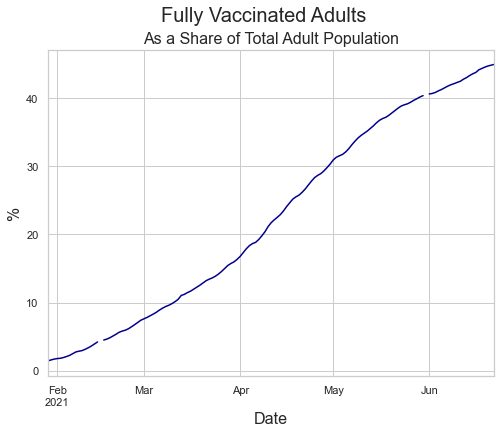

In [8]:
vaccination['people_fully_vaccinated_per_hundred'].plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Fully Vaccinated Adults', fontsize=20)
plt.title('As a Share of Total Adult Population', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)

Text(0, 0.5, '%')

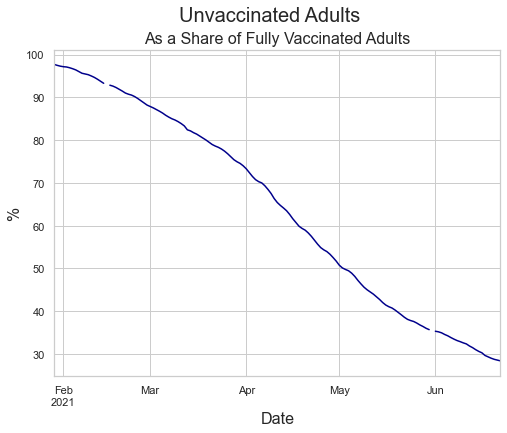

In [9]:
vaccination['outstanding'].plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Unvaccinated Adults', fontsize=20)
plt.title('As a Share of Fully Vaccinated Adults', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)

Text(0, 0.5, '%')

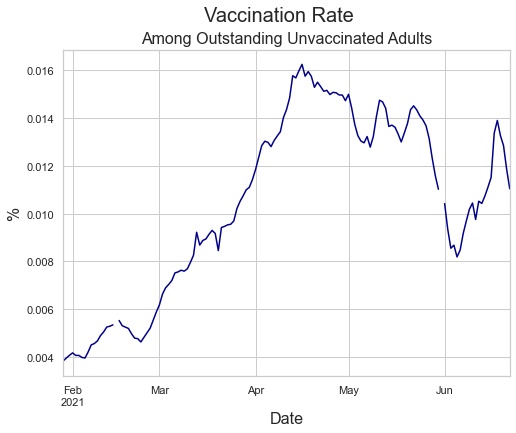

In [10]:
vaccination['daily_vaccinations_per_million'].plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Vaccination Rate', fontsize=20)
plt.title('Among Outstanding Unvaccinated Adults', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)

#### Notes

1. **Trends**.  Are there consistent upward or downward patterns?
2. **Serial dependence**.  Are there positive or negative correlations of time-adjacent observations?
3. **Stationarity**.  Would the series diverge to $\pm \infty$ in finite time? 

### How We Will Proceed 

1. Start with Markov processes and how to model them.
2. Turn to formal times series models building up from white noise processes.
3. Autoregressive models of order 1, AR(1).  
4. The unit root: linking AR(1) to Markov processes.
5. Moving average models.  
6. ARMA.
7. Filtering trends and cyclicality.
    * Many examples throughout.

## Introduction to Markov Processes

* Markov processes are already familiar to anyone with a calendar.
* Everything I need to know about **tomorrow** is contained by my knowledge of **today**.
* Markov processes are a fundamental building block of time series.

In [11]:
print("The Calendar: A Deterministic Markov Transition Matrix")
table = [[" ", "S", "M", "T", "W", "T", "F", "S"],
         ["S", "0", "1", "0", "0", "0", "0", "0",],
         ["M", "0", "0", "1", "0", "0", "0", "0",],
         ["T", "0", "0", "0", "1", "0", "0", "0",],
         ["W", "0", "0", "0", "0", "1", "0", "0",],
         ["T", "0", "0", "0", "0", "0", "1", "0",],
         ["F", "0", "0", "0", "0", "0", "0", "1",],
         ["S", "1", "0", "0", "0", "0", "0", "0",],]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

The Calendar: A Deterministic Markov Transition Matrix
╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│   │ S │ M │ T │ W │ T │ F │ S │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ S │ 0 │ 1 │ 0 │ 0 │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ M │ 0 │ 0 │ 1 │ 0 │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ T │ 0 │ 0 │ 0 │ 1 │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ W │ 0 │ 0 │ 0 │ 0 │ 1 │ 0 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ T │ 0 │ 0 │ 0 │ 0 │ 0 │ 1 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ F │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 1 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ S │ 1 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛



In [12]:
print("Day of Week Vector: Today is Wednesday")
table = [["S", "M", "T", "W", "T", "F", "S"],
         ["0", "0", "0", "1", "0", "0", "0",]]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

Day of Week Vector: Today is Wednesday
╒═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ S │ M │ T │ W │ T │ F │ S │
├───┼───┼───┼───┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 1 │ 0 │ 0 │ 0 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╛



* How do we iterate the day of the week?  Today is Wednesday.  What is tomorrow?



* day of week vector * Markov transition matrix = ? 

In [13]:
# Let's find out.

MT = np.matrix('0 1 0 0 0 0 0; 0 0 1 0 0 0 0; 0 0 0 1 0 0 0; 0 0 0 0 1 0 0; 0 0 0 0 0 1 0; 0 0 0 0 0 0 1; 1 0 0 0 0 0 0')
dow = np.matrix('0 0 0 1 0 0 0')

print("Markov Transition Matrix")
print(MT)
print()
print("Today")
print(dow)
print()
print("Tomorrow")
print (dow * MT)
print()
print("The Day After Tomorrow")
print (dow * MT * MT)
print()
print("The Day After Tomorrow Using Linear Algebra")
print (dow * np.linalg.matrix_power(MT, 2))

Markov Transition Matrix
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0]]

Today
[[0 0 0 1 0 0 0]]

Tomorrow
[[0 0 0 0 1 0 0]]

The Day After Tomorrow
[[0 0 0 0 0 1 0]]

The Day After Tomorrow Using Linear Algebra
[[0 0 0 0 0 1 0]]


* Obviously, if today is Tuesday, tomorrow is Wednesday.
    * Because tomorrow is Wednesday, the day after tomorrow is Thursday.  
    * You do this every day.  
    * Moreover, this simple deterministic example highlights the important aspects of Markov processes (of which Markov Chain Monte Carlo is a developed).



* A Markov process records movement of a state vector through time.  In this example, the state vector is the day of the week.



* Based on the Markov process, my knowledge of tomorrow is dependent *only* on what I know today.  



* It does not matter what I knew yesterday.  Using this deterministic example, I know it will be Thursday tomorrow because I know it is Wednesday today.  


* It does not matter (and I do not need to know) that yesterday was Tuesday.



* Consider the idea behind the Efficient Markets Hypothesis: $E_t(p_{t+1})=p_t+\epsilon_{t+1}$.  What does this look like?

### Formally
* A Markov process $\{x_t\}$ is a stochastic process with the property that, given the outcome (or *realization*) of $\{x_t\}$, the outcomes (or *realizations*) of $\{x_s\}$ for $s > t$ are unaffected by the outcomes of $\{x_u\}$ for $u < t$.  
* Therefore, $Pr(x_t = j  \big| x_{t-1} = i_{t-1}, x_{t-2} = i_{t-2}, ...) = Pr(x_t = j \big| x_{t-1} = i_{t-1})$.
    * In other words, everything I need to know about tomorrow is contained in what I know today.  I do not have look further back into the past.
* Write the above as $P_{ij}$: transition probability from state i to state j.  Knowing last period’s outcome is all we need.

#### Notes

* Application 1: A Rat on the Subway.
* We will use a Markov matrix of transition probabilities to iterate a system series through time.
* We multiple the **state vector** at time $t$ (or the system at time t) by the transition probabilities.
* This yields the probabilitistic forecast of the **state vector** in time $t+1$.
* We did this using the calendar.

#### Setup

* Let's apply this to something non-deterministic using a NYC Subway rat moving randomly across subway tracks.
* If on Track A, Pr(stays) = 1/2 and Pr(moves to B) = 1/2.
* If on Track B, Pr(stays) = 1/2, Pr(move to A) = 1/4, and Pr(moves to C) = 1/4.
* If on Track C, Pr(stays) = 1/2 and Pr(moves to C) = 1/2.

In [14]:
print("A Rat in a NYC Subway Tunnel")
table = [[" ", "Track A", "Track B", "Track C"],
        ["Track A", "1/2", "1/2", "0"],
        ["Track B", "1/4", "1/2", "1/4"],
        ["Track C", "0", "1/2", "1/2"],]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

MT = np.matrix('0.5 0.5 0; 0.25 0.5 0.25; 0 0.5 0.5')
print("As an Numpy matrix")
print(MT)

A Rat in a NYC Subway Tunnel
╒═════════╤═════════╤═════════╤═════════╕
│         │ Track A │ Track B │ Track C │
├─────────┼─────────┼─────────┼─────────┤
│ Track A │ 1/2     │ 1/2     │ 0       │
├─────────┼─────────┼─────────┼─────────┤
│ Track B │ 1/4     │ 1/2     │ 1/4     │
├─────────┼─────────┼─────────┼─────────┤
│ Track C │ 0       │ 1/2     │ 1/2     │
╘═════════╧═════════╧═════════╧═════════╛

As an Numpy matrix
[[0.5  0.5  0.  ]
 [0.25 0.5  0.25]
 [0.   0.5  0.5 ]]


#### Notes
1. Place the rat on Track A.
2. Iterate the rate through time.
3. The future location of the rat is inherently probabilistic.

In [15]:
rat = np.matrix('1 0 0')

In [16]:
for i in range(1, 21):
    print('Probability rat in on Track A, B, or C at time t + %i' % (i))
    print(rat * np.linalg.matrix_power(MT, i))
    print()

Probability rat in on Track A, B, or C at time t + 1
[[0.5 0.5 0. ]]

Probability rat in on Track A, B, or C at time t + 2
[[0.375 0.5   0.125]]

Probability rat in on Track A, B, or C at time t + 3
[[0.3125 0.5    0.1875]]

Probability rat in on Track A, B, or C at time t + 4
[[0.28125 0.5     0.21875]]

Probability rat in on Track A, B, or C at time t + 5
[[0.265625 0.5      0.234375]]

Probability rat in on Track A, B, or C at time t + 6
[[0.2578125 0.5       0.2421875]]

Probability rat in on Track A, B, or C at time t + 7
[[0.25390625 0.5        0.24609375]]

Probability rat in on Track A, B, or C at time t + 8
[[0.25195312 0.5        0.24804688]]

Probability rat in on Track A, B, or C at time t + 9
[[0.25097656 0.5        0.24902344]]

Probability rat in on Track A, B, or C at time t + 10
[[0.25048828 0.5        0.24951172]]

Probability rat in on Track A, B, or C at time t + 11
[[0.25024414 0.5        0.24975586]]

Probability rat in on Track A, B, or C at time t + 12
[[0.25012

* Start the rat on Track C and repeat.

In [17]:
rat = np.matrix('0 0 1')
for i in range(1, 21):
    print('Probability rat in on Track A, B, or C at time t + %i' % (i))
    print(rat * np.linalg.matrix_power(MT, i))
    print()

Probability rat in on Track A, B, or C at time t + 1
[[0.  0.5 0.5]]

Probability rat in on Track A, B, or C at time t + 2
[[0.125 0.5   0.375]]

Probability rat in on Track A, B, or C at time t + 3
[[0.1875 0.5    0.3125]]

Probability rat in on Track A, B, or C at time t + 4
[[0.21875 0.5     0.28125]]

Probability rat in on Track A, B, or C at time t + 5
[[0.234375 0.5      0.265625]]

Probability rat in on Track A, B, or C at time t + 6
[[0.2421875 0.5       0.2578125]]

Probability rat in on Track A, B, or C at time t + 7
[[0.24609375 0.5        0.25390625]]

Probability rat in on Track A, B, or C at time t + 8
[[0.24804688 0.5        0.25195312]]

Probability rat in on Track A, B, or C at time t + 9
[[0.24902344 0.5        0.25097656]]

Probability rat in on Track A, B, or C at time t + 10
[[0.24951172 0.5        0.25048828]]

Probability rat in on Track A, B, or C at time t + 11
[[0.24975586 0.5        0.25024414]]

Probability rat in on Track A, B, or C at time t + 12
[[0.24987

* Start the rat on Track B and repeat.

In [18]:
rat = np.matrix('0 1 0')
for i in range(1, 21):
    print('Probability rat in on Track A, B, or C at time t + %i' % (i))
    print(rat * np.linalg.matrix_power(MT, i))
    print()

Probability rat in on Track A, B, or C at time t + 1
[[0.25 0.5  0.25]]

Probability rat in on Track A, B, or C at time t + 2
[[0.25 0.5  0.25]]

Probability rat in on Track A, B, or C at time t + 3
[[0.25 0.5  0.25]]

Probability rat in on Track A, B, or C at time t + 4
[[0.25 0.5  0.25]]

Probability rat in on Track A, B, or C at time t + 5
[[0.25 0.5  0.25]]

Probability rat in on Track A, B, or C at time t + 6
[[0.25 0.5  0.25]]

Probability rat in on Track A, B, or C at time t + 7
[[0.25 0.5  0.25]]

Probability rat in on Track A, B, or C at time t + 8
[[0.25 0.5  0.25]]

Probability rat in on Track A, B, or C at time t + 9
[[0.25 0.5  0.25]]

Probability rat in on Track A, B, or C at time t + 10
[[0.25 0.5  0.25]]

Probability rat in on Track A, B, or C at time t + 11
[[0.25 0.5  0.25]]

Probability rat in on Track A, B, or C at time t + 12
[[0.25 0.5  0.25]]

Probability rat in on Track A, B, or C at time t + 13
[[0.25 0.5  0.25]]

Probability rat in on Track A, B, or C at time 

In [19]:
rat = np.matrix('0.75, 0.15, 0.10')
print('Probability rat is on Track A, B, or C in the long run')
print(rat * np.linalg.matrix_power(MT, 100000))

Probability rat is on Track A, B, or C in the long run
[[0.25 0.5  0.25]]


#### Notes

* A **limiting probability distribution** is obtained by raising the transition matrix to an arbitrarily large number.
* Asymptotically, it does not matter on which track the rat started.
* You could consider this is be a long run probabilistic forecast.
* Suppose you want to kill the rat, and you could electrify only one track.  
* Which track would you electrify?
* This holds if we randomly start the rat on any track.

 ### Markov Advances Statistical Theory
 
* Who Was [Andrei Markov](https://en.wikipedia.org/wiki/Andrey_Markov)?



* Until Markov's time, the CLT relied on Leplace's idea of independent and identical experiments.
    * Laplace proved that test statistics are asymptotically normally distributed.
    * Leplace also prove the theory of inverse probability, the heart of Bayesian simulation.
    * In the early 1900's, Fisher, Neyman, and the Pearsons (father and son) develop the classical interpretation of statistical inference through the use of confidence intervals (from Leplace)
    * Markov studied **DGPs** that were not independent: **yesterday affects today**.
    * He proved the idea of **limiting distributions**, the equivalent the CLT.
    * Markov processes are widely used in finance.

#### Notes

* Application 2: A Random Walk.
* Set an arbitrary starting point and iterate the system using a simple Markov process.
* Each second, this Markov process can move up 1 or it can move down, which it does at random.
* Pr(up) = Pr(down) = 0.5.

Let:
* pos be starting position.
* draws be random integers, {0, 1}.
* step be -1 if random draw is 0 and +1 if random draw is 1.
* walk be the vector containing each step.

Text(0.5, 0, 'Seconds')

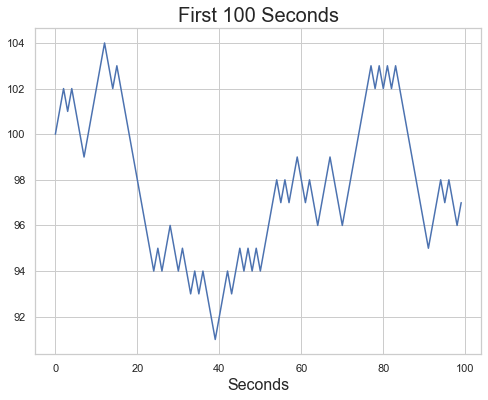

In [20]:
random.seed(1234)

pos = 100  
walk = [pos] 
nsteps = 10000 
for i in range(nsteps):
    step = 1 if np.random.randint(0, 2) else -1
    pos += step
    walk.append(pos)

plt.figure(figsize=(8, 6))
plt.plot(walk[0:100])
plt.title('First 100 Seconds', fontsize=20)
plt.xlabel('Seconds', fontsize=16)

#### Notes

1. **Trends**.  Are there consistent upward or downward patterns?
2. **Serial dependence**.  Are there positive or negative correlations of time-adjacent observations?
3. **Stationarity**.  Would the series diverge to $\pm \infty$ in finite time? 

Text(0.5, 0, 'Seconds')

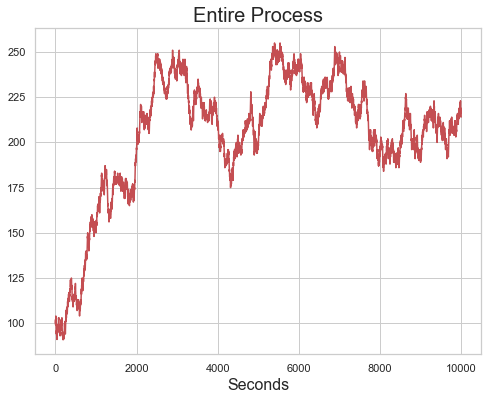

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(walk, 'r')
plt.title("Entire Process", fontsize=20)
plt.xlabel('Seconds', fontsize=16)

#### What Does This Look Like?

Text(0, 0.5, '$')

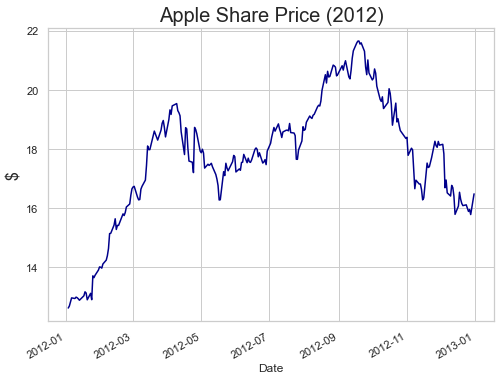

In [22]:
start, end = "2012-01-01", "2013-01-01"
aapl = web.get_data_yahoo('aapl', start=start, end=end)['Adj Close']
aapl.plot(color = 'darkblue', figsize=(8, 6))
plt.title('Apple Share Price (2012)', fontsize=20)
plt.ylabel('$', fontsize=16)

#### Notes

* Markov Process Application 3: A Drunken Sailor on a Mountaintop
* A drunken sailor is dropped off at the center of a Cartesian mountain.
* The sailer stumbles forward and backward, and then to the left and to the right.
* Each stumble is random because he is drunk.

In [23]:
random.seed(1023)
edge = 100
nsteps = 10000

pos1, pos2 = 0, 0  
walk1, walk2 = [pos1], [pos2] 
for i in range(nsteps):
    step1 = 1 if np.random.randint(0, 2) else -1 
    step2 = 1 if np.random.randint(0, 2) else -1
    pos1 += step1
    pos2 += step2
    if np.abs(pos1) > 100 or np.abs(pos2) > 100:
        print("Sailor fell off the moutain at coordinates", pos1, pos2, "on step", i)
        break
    walk1.append(pos1)
    walk2.append(pos2)

Sailor fell off the moutain at coordinates -101 85 on step 7296


(-100.0, 100.0)

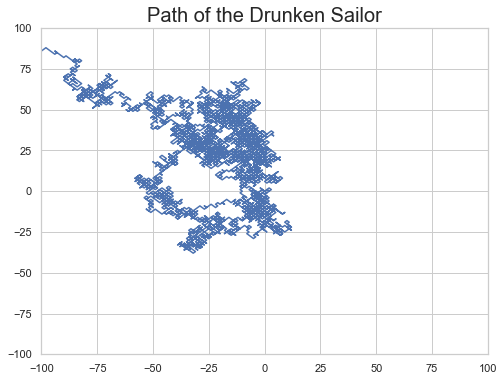

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(walk1, walk2, 'b')
plt.title("Path of the Drunken Sailor", fontsize=20)
plt.xlim(-edge, edge)
plt.ylim(-edge, edge)

### Absorbing States

* Suppose there existed an **absorbing state**, from which a system could not escape.  
* How could we model this?  
* Consider our subway rat, and suppose one rail was **in fact** electrified.  
* If the rat touches it, it dies.

In [25]:
print("A Rat in a NYC Subway Tunnel")
table = [[" ", "Track A", "Track B", "Track C"],
        ["Track A", "1", "0", "0"],
        ["Track B", "1/4", "1/2", "1/4"],
        ["Track C", "0", "1/2", "1/2"],]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

MT = np.matrix('1 0 0; 0.25 0.5 0.25; 0 0.5 0.5')
print("As an Numpy matrix")
print(MT)

A Rat in a NYC Subway Tunnel
╒═════════╤═════════╤═════════╤═════════╕
│         │ Track A │ Track B │ Track C │
├─────────┼─────────┼─────────┼─────────┤
│ Track A │ 1       │ 0       │ 0       │
├─────────┼─────────┼─────────┼─────────┤
│ Track B │ 1/4     │ 1/2     │ 1/4     │
├─────────┼─────────┼─────────┼─────────┤
│ Track C │ 0       │ 1/2     │ 1/2     │
╘═════════╧═════════╧═════════╧═════════╛

As an Numpy matrix
[[1.   0.   0.  ]
 [0.25 0.5  0.25]
 [0.   0.5  0.5 ]]


In [26]:
rat = np.matrix('0 0 1')
print('Probability rat in on Track A, B, or C in the long run')
print(rat * np.linalg.matrix_power(MT, 100))

Probability rat in on Track A, B, or C in the long run
[[9.99999840e-01 9.38759157e-08 6.63802966e-08]]


## White Noise Processes

Markov processes give us one way to model time series.  

We need more building blocks to develop the DGPs we think form the foundation of time series outcomes.  Let’s start with the simplest, so-called “white noise”.  Like Markov processes, white noise (WN) processes are also ubiquitous in modeling.  Eonomics and the physical sciences use Brownian motion (Wiener processes in stochastic calculus) to describe the evolution of many systems.

The definition in this context is simple: independent draws from some probability distribution with zero mean and finite variance.  We will focus on so-called “Gaussian” white noise: draws from N(0,1).  Each “period” we draw at random from N(0,1) and simply connect the dots over “time”.

## Characteristics

White noise processes arise independent draws from some probability distribution with zero mean and finite variance.  Therefore, by design, the resulting time series process:

1. Has no trend.
2. Has no serial dependence.  (Yesterday does not matter for today.  Today does not matter for tomorrow.)
3. Is stationary.

As such, it is an ideal building block.

(-6.0, 6.0)

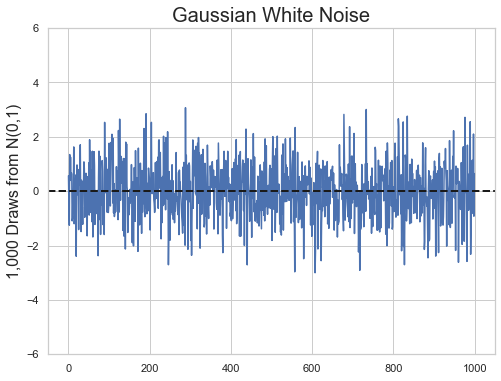

In [27]:
y = np.random.normal(0, 1, 1000)

plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Gaussian White Noise', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)
plt.ylabel('1,000 Draws from N(0,1)', fontsize=16)
plt.ylim(-6, 6)

(-6.0, 6.0)

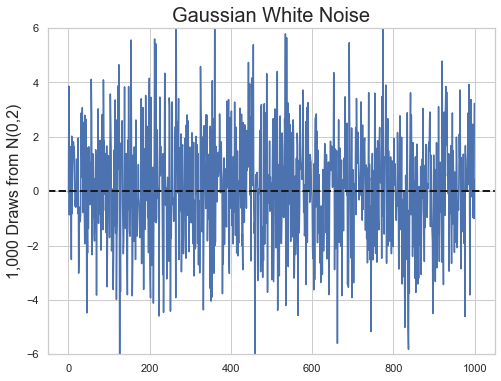

In [28]:
# Increase the variance

y = np.random.normal(0, 2, 1000)

plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Gaussian White Noise', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)
plt.ylabel('1,000 Draws from N(0,2)', fontsize=16)
plt.ylim(-6, 6)

(-6.0, 6.0)

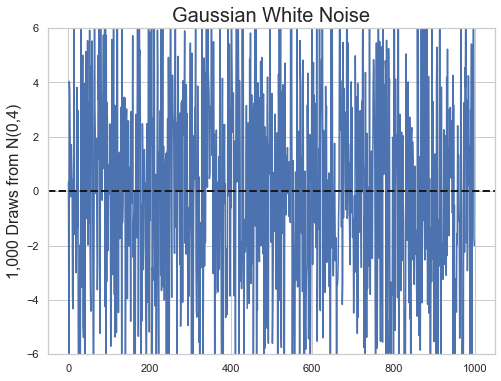

In [29]:
# And yet more

y = np.random.normal(0, 4, 1000)

plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Gaussian White Noise', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)
plt.ylabel('1,000 Draws from N(0,4)', fontsize=16)
plt.ylim(-6, 6)

#### Notes

* Does the higher variance matter?
* Increasing the variance increases the “noise” of white noise.  
* As long as the variance is finite, the characteristics of white noise processes remain unchanged and equally appealing.  
* Therefore, let's focus on white noise processes using N(0,1) using a simple example.

### Data Science: Sorting Signal from Noise

* Recall I distinguished the use of algorithms from the act of hypothesis testing.
* The purpose of the algorithm is to separate the signal from the noise.
* Here are some simple graphs to highlight the purpose of the algorithm.

Text(0.5, 0, 'Time')

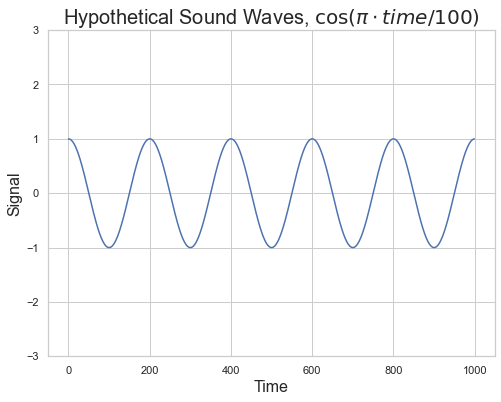

In [30]:
time = np.arange(0, 1000, 1)
y = np.cos(np.pi * time / 100)

plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Hypothetical Sound Waves, $\cos(\pi \cdot time/100)$', fontsize=20)
plt.ylim(-3, 3)
plt.ylabel('Signal', fontsize=16)
plt.xlabel('Time', fontsize=16)

Text(0.5, 0, 'Time')

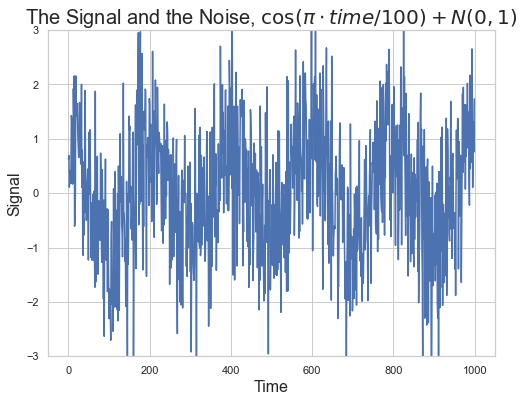

In [31]:
x = y + np.random.normal(0, 1, len(time))
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
plt.title(r'The Signal and the Noise, $\cos(\pi \cdot time/100)+N(0,1)$', fontsize=20)
plt.ylim(-3, 3)
plt.ylabel('Signal', fontsize=16)
plt.xlabel('Time', fontsize=16)

### Autoregressive Processes of Order 1: AR(1)

* We can write the AR(1) process as follows: $y_t = \rho y_{t-1} + \epsilon_t$ for $|\rho|<1$.  This process would model the rule that, "Today is mostly yesterday plus a little noise."  



* Let $\rho$ denote the extent to which yesterday affects today, assuming a diminishing effect or $|\rho|<1$.  Often, we refer to the $\epsilon$'s as "innovations".  



* Therefore, today's realization, $y_t$, is primarily yesterday's realization, $\rho y_{t-1}$, plus today's innovation, $\epsilon_t$.



* Let's build an AR(1) process from the bottom up.
    * $y_1 = \epsilon_1$: Take a single draw from $N(0,1)$ to begin the process.
    * $y_2 = \rho y_1 + \epsilon_2$: Take another single draw and continue to build the process.
    * $y_3 = \rho y_2 + \epsilon_3$



* And so on,
    * $y_T = \rho y_{T-1} + \epsilon_T$



* Generally,
    * $y_t = \rho y_{t-1} + \epsilon_t$

#### Notes

* Let's generate and graph, changing the value of $\rho$ to particular values.
* Start with $\rho = 0$
* Examine with various values of $\rho$: 0, 0.5, -0.5, 0.9, 0.99.

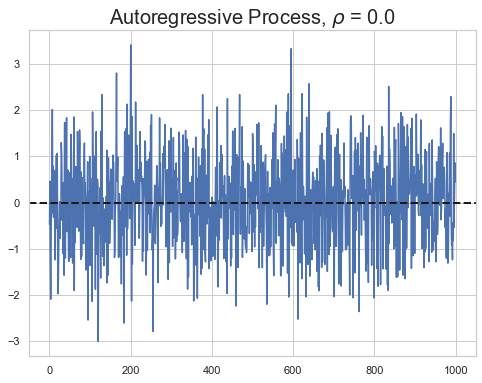

In [32]:
np.random.seed(2233)
T = 1000
rho = 0.0
y = np.zeros(T)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)
    
r = rho
plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

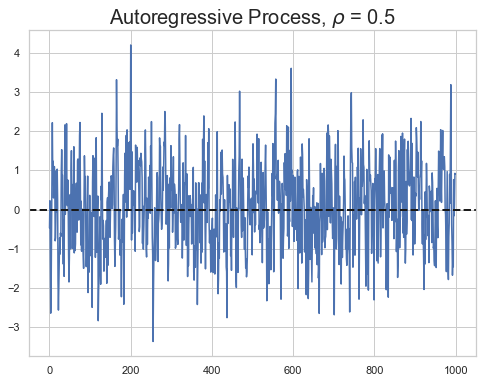

In [33]:
np.random.seed(2233)
T = 1000
rho = 0.5
y = np.zeros(T)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)
    
r = rho
plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

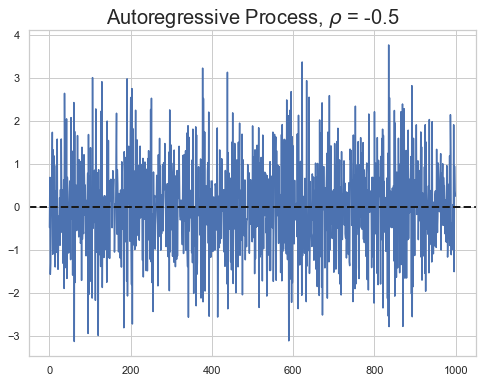

In [34]:
np.random.seed(2233)
T = 1000
rho = -0.5
y = np.zeros(T)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)
    
r = rho
plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

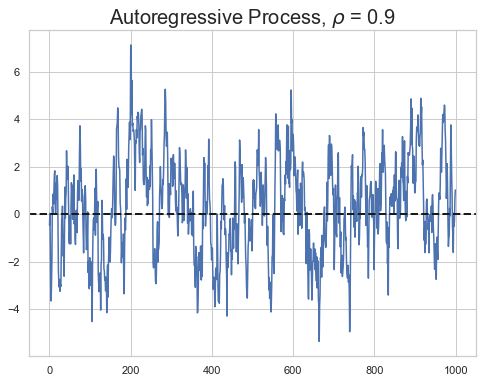

In [35]:
np.random.seed(2233)
T = 1000
rho = 0.9
y = np.zeros(T)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)
    
r = rho
plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

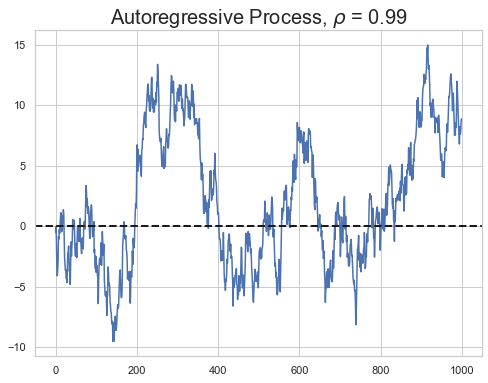

In [36]:
np.random.seed(2233)
T = 1000
rho = 0.99
y = np.zeros(T)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)
    
r = rho
plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

#### Notes

* The stationarity of the AR(1) can be derived mathematically, which we will do.
* Let's first explore this property through Monte Carlo simulation.
* The outer loop will vary over ranges of rho.
* The inner loop will generate a large number of simulated values to determine mean and variance.
* We talked about 'Numba' in the first session.

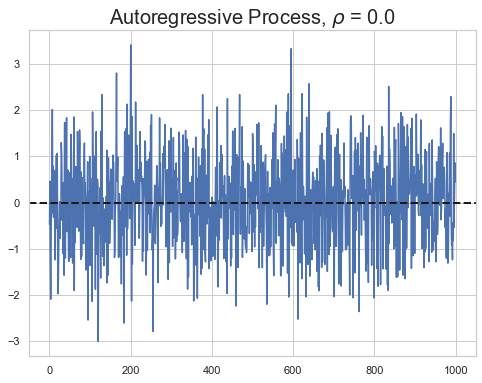

In [37]:
np.random.seed(2233)
T = 1000
rho = 0.0
y = np.zeros(T)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)
    
r = rho
plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

In [38]:
def Ergo(rho, T):
    
    np.random.seed(4955)
    mean = np.zeros((len(rho),), dtype=np.float)
    var = np.zeros((len(rho),), dtype=np.float)
           
    for i in range(len(rho)):
        y = np.zeros(T)
        y[0] = np.random.normal(0, 1)
        for t in range(1, T):
            y[t] = rho[i] * y[t-1] + np.random.normal(0, 1)
        
        mean[i] = np.mean(y)
        var[i] = np.var(y)
    
    return(mean, var)
            
T = 99999
rho = np.arange(-0.99, 0.99, .05)

mean, var = Ergo(rho, T)

Text(0.5, 0, 'Value of $\\rho$')

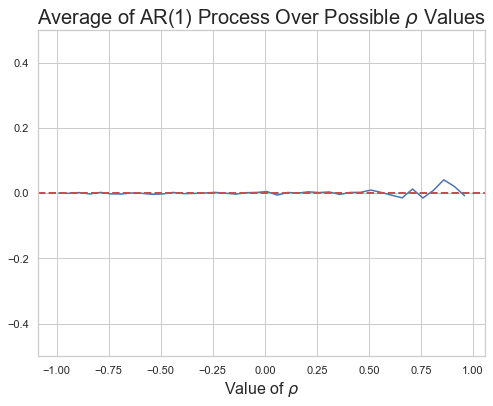

In [39]:
plt.figure(figsize = (8, 6))
plt.plot(rho, mean, 'b')
plt.title(r'Average of AR(1) Process Over Possible $\rho$ Values', fontsize=20)
plt.ylim(-.5, .5)
plt.axhline(0, color='r', ls='--', lw=2)
plt.xlabel(r'Value of $\rho$', fontsize=16)

Text(0.5, 0, 'Value of $\\rho$')

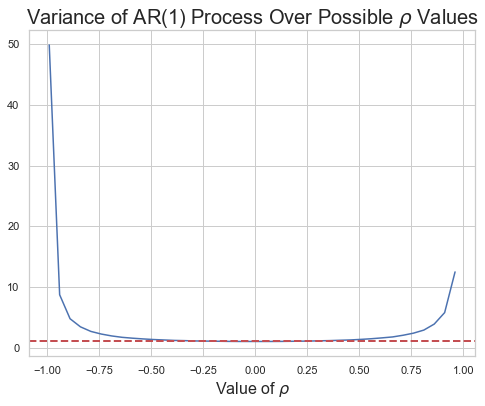

In [40]:
plt.figure(figsize = (8, 6))
plt.plot(rho, var, 'b')
plt.title(r'Variance of AR(1) Process Over Possible $\rho$ Values', fontsize=20)
plt.axhline(1, color='r', ls='--', lw=2)
plt.xlabel(r'Value of $\rho$', fontsize=16)

* Therefore, we can see through MC simulation that the AR(1) process is stationary as long as $|\rho|<1$.  But let's make the point mathematically rigorous using the mathematics of *recursion*.
    * Eq.0: $y_t = \rho y_{t-1} + \epsilon_t$.
    * Eq.1: $y_{t-1} = \rho y_{t-2} + \epsilon_{t-1}$.
    * Eq.2: $y_{t-2} = \rho y_{t-3} + \epsilon_{t-2}$.



* Substitute Eq.2 into Eq.1 to obtain $y_{t-1} = \rho^2 y_{t-3} + \rho \epsilon_{t-2} + \epsilon_{t-1}$ which is substituted into Eq.0 to obtain:
    * $y_{t} = \rho^3 y_{t-3} + \rho^2 \epsilon_{t-2} + \rho \epsilon_{t-1} + \epsilon_{t}$



* This is the process of *mathematical recursion*, and the equation hints at a solution.
    * $\displaystyle {y_{t} = \rho^k y_{t-k} + \sum_{j=1}^k \rho^{j-1} \epsilon_{t-j+1}}$



* The first term to the right of $=$ is where $y_t$ was $k$ periods ago, while the second is the sum of white noise terms.  Suppose we could go backward *infinitely far*?
    * $\displaystyle {\lim_{k \rightarrow \infty} \left( \rho^k y_{t-k} + \sum_{j=1}^k \rho^{j-1} \epsilon_{t-j+1}\right)}$



* The first term vanishes because $|\rho|<1$.  Therefore,
    * $\displaystyle {y_t = \sum_{j=1}^\infty \rho^{j-1} \epsilon_{t-j+1}}$.



* Therefore, $y_t$ is the infinite sum of white noise innovations that geometrically decay the further back in time an innovation occurred.  As long as the $\epsilon$'s are stationary (which we've assumed), $y_t$ is stationary.



* This representation also makes calculating the mean and variance much easier.
    * $\displaystyle {E(y_t) = E\left(\sum_{j=1}^\infty \rho^{j-1} \epsilon_{t-j+1}\right) = \sum_{j=1}^\infty \rho^{(j-1)} E(\epsilon_{t-j+1}) = 0}$
    * $\displaystyle {Var(y_t) = Var\left(\sum_{j=1}^\infty \rho^{j-1} \epsilon_{t-j+1}\right) = \sum_{j=1}^\infty \rho^{2(j-1)} Var(\epsilon_{t-j+1}) = \sum_{j=1}^\infty \rho^{2(j-1)} = \frac{1}{1-\rho^2}}$



* These results can be seen in the graphs above, where the red horizontal lines are 0 and 1, respectively.  (Note the value of doing this both with MC simulation as well as with mathematics.)



### Autocorellation
* Consider the "autocovariance" function, which is the covariance between time-ajacent realizations.  Because the process is mean zero, the autocovariance is simply the expectation of the product:
    * $\displaystyle {Cov(y_t, y_{t-1})= E(y_t \cdot y_{t-1}) = E\left(\sum_{j=1}^\infty \rho^{j-1} \epsilon_{t-j+1} \cdot \sum_{j=1}^\infty \rho^{j-1} \epsilon_{t-j}\right)}$



* This looks like a mess, but it is not.  
    * Remember, the $\epsilon$'s are independent across time, so whenever their subscripts **do not match**, the expected product is zero.  
     * We pick up a $\rho$ for the one time period when $\epsilon$ is the same, and we still have the infinite sum of $\rho^2$.  
     
     
     
* Therefore, 
    * $\displaystyle {Cov(y_t, y_{t-1})= E(y_t \cdot y_{t-1}) = \frac{\rho}{1-\rho^2}}$



* Indeed, for any $k$,
    * $\displaystyle {Cov(y_t, y_{t-k})= \frac{\rho^k}{1-\rho^2}}$



* More importantly, since correlation is defined as covariance divided by variance, for any AR(1) process, $y_t$, the "autocorrelation" function is simply:
    * $\displaystyle {Corr(y_t, y_{t-k})= \rho^k}$



* Here, autocorrelation simply means "correlated with itself through time".



* Therefore, in summary, the AR(1) process, $y_t$, has the following characteristics:



1. Zero mean.
2. Finite variance.
3. Autocorrelation function that decays geometrically, $\rho^k$, over $k$ periods.  Note that for $k=0$, correlation is 1 (as it should be).



* By time series cannon, we examine **autocorrelation functions** (ACF).

#### How Do These Autocorrelation Functions Appear?

Text(0.5, 0, 'Time')

<Figure size 576x432 with 0 Axes>

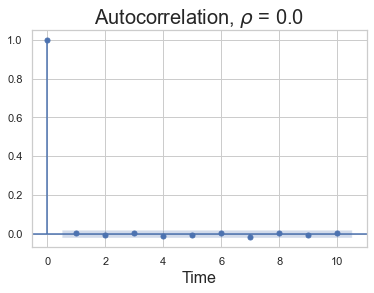

In [41]:
T = 9999
rho = 0.0
y = np.zeros(T+1)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)

y = pd.DataFrame(y)

fig = plt.figure(figsize=(8, 6))
fig = sma.graphics.tsa.plot_acf(y.values.squeeze(), lags=10)
plt.title(r'Autocorrelation, $\rho$ = %r' %(rho), fontsize=20)
plt.xlabel('Time', fontsize=16)

Text(0.5, 0, 'Time')

<Figure size 576x432 with 0 Axes>

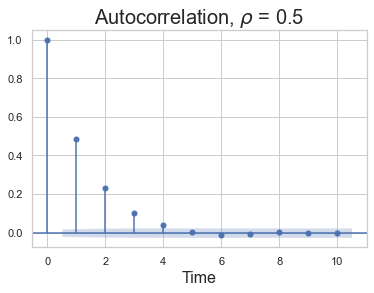

In [42]:
T = 9999
rho = 0.5
y = np.zeros(T+1)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)

y = pd.DataFrame(y)

fig = plt.figure(figsize=(8, 6))
fig = sma.graphics.tsa.plot_acf(y.values.squeeze(), lags=10)
plt.title(r'Autocorrelation, $\rho$ = %r' %(rho), fontsize=20)
plt.xlabel('Time', fontsize=16)

Text(0.5, 0, 'Time')

<Figure size 576x432 with 0 Axes>

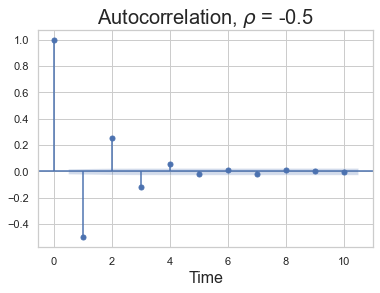

In [43]:
T = 9999
rho = -0.5
y = np.zeros(T+1)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)

y = pd.DataFrame(y)

fig = plt.figure(figsize=(8, 6))
fig = sma.graphics.tsa.plot_acf(y.values.squeeze(), lags=10)
plt.title(r'Autocorrelation, $\rho$ = %r' %(rho), fontsize=20)
plt.xlabel('Time', fontsize=16)

Text(0.5, 0, 'Time')

<Figure size 576x432 with 0 Axes>

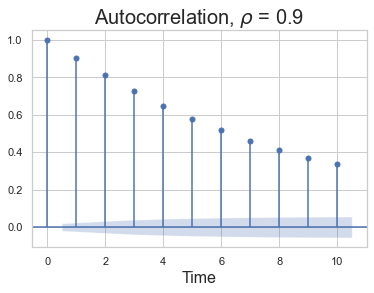

In [44]:
T = 9999
rho = 0.9
y = np.zeros(T+1)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)

y = pd.DataFrame(y)

fig = plt.figure(figsize=(8, 6))
fig = sma.graphics.tsa.plot_acf(y.values.squeeze(), lags=10)
plt.title(r'Autocorrelation, $\rho$ = %r' %(rho), fontsize=20)
plt.xlabel('Time', fontsize=16)

Text(0.5, 0, 'Time')

<Figure size 576x432 with 0 Axes>

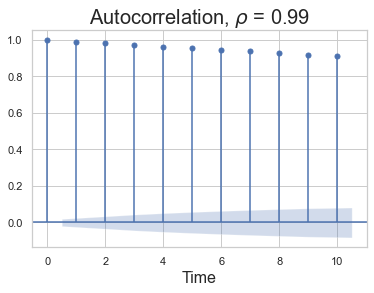

In [45]:
T = 9999
rho = 0.99
y = np.zeros(T+1)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)

y = pd.DataFrame(y)

fig = plt.figure(figsize=(8, 6))
fig = sma.graphics.tsa.plot_acf(y.values.squeeze(), lags=10)
plt.title(r'Autocorrelation, $\rho$ = %r' %(rho), fontsize=20)
plt.xlabel('Time', fontsize=16)

### Notes
* Again, consider the EMH: $E_t(p_{t+1})=p_t+\epsilon_{t+1}$.  What does this look like?



* My best guess of tomorrow's price, $E_t(p_{t+1})$, is today's price, $p_t$ plus tomorrow's innovation, $\epsilon_{t+1}$.  



* *And you cannot forecast tomorrow's innovation*.



* But, $E_t(p_{t+1}) - p_t = \epsilon_{t+1}$, where the term on the left is a price change (or a return) and the term on the right is not forecastable.  **This is the essence of the EMH**.

## Moving Average Models
* As we have discussed, the linear algorithm is method of dimensionality reduction.  



* A similar approach, *data smoothing*, is a moving average.  Two examples are the three-month *moving average*, which has no standardized definition: 
    * $\bar{y} = \displaystyle{\frac{y_{t-2} + y_{t-1} + y_{t}}{3}}$ if $t$ is measured monthly
    * What would a seven-week moving average look like?
    * $\bar{y} = \displaystyle{\frac{y_{t+1} + y_{t} + y_{t-1}}{3}}$ as a *sliding window*



* A more general representation of this moving-average process is:
    * $y_t = \epsilon_t + \theta \cdot \epsilon_{t-1}$



* $\theta$ is viewed as a weight.  Therefore, the time series, $y_t$, is the weighted sum of today's innovation, $\epsilon_t$ and yesterday's innovation, $\theta \cdot \epsilon_{t-1}$.  

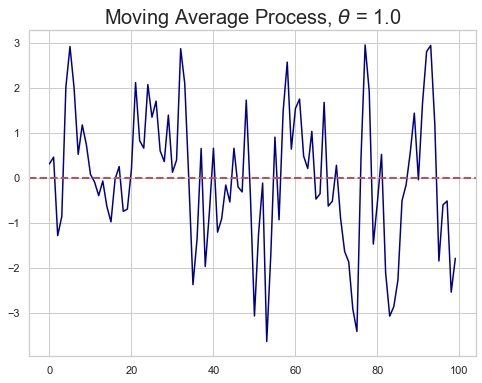

In [46]:
T = 100
theta = 1.0
y = np.zeros(T)
e = np.zeros(T)

e[0] = np.random.normal(0, 1)
y[0] = e[0]

for t in range(1, T):
    e[t] = np.random.normal(0, 1)
    y[t] = e[t] + theta * e[t-1] 
    
t = theta
plt.figure(figsize = (8, 6))
plt.plot(y, 'darkblue')
plt.title(r'Moving Average Process, $\theta$ = %r' %(t), fontsize=20)
plt.axhline(0, color='r', ls='--', lw=2)

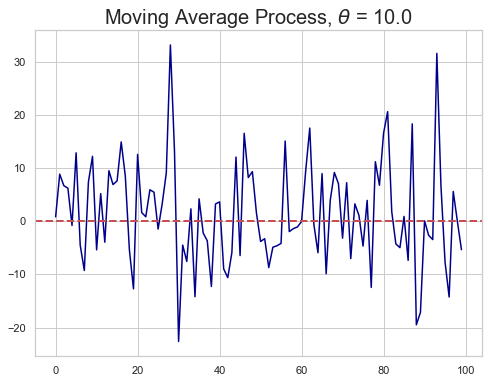

In [47]:
T = 100
theta = 10.0
y = np.zeros(T)
e = np.zeros(T)

e[0] = np.random.normal(0, 1)
y[0] = e[0]

for t in range(1, T):
    e[t] = np.random.normal(0, 1)
    y[t] = e[t] + theta * e[t-1] 
    
t = theta
plt.figure(figsize = (8, 6))
plt.plot(y, 'darkblue')
plt.title(r'Moving Average Process, $\theta$ = %r' %(t), fontsize=20)
plt.axhline(0, color='r', ls='--', lw=2)

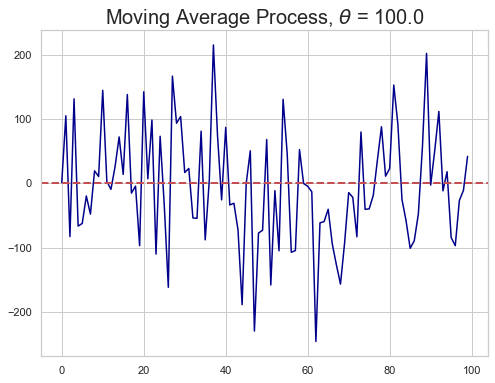

In [48]:
T = 100
theta = 100.0
y = np.zeros(T)
e = np.zeros(T)

e[0] = np.random.normal(0, 1)
y[0] = e[0]

for t in range(1, T):
    e[t] = np.random.normal(0, 1)
    y[t] = e[t] + theta * e[t-1] 
    
t = theta
plt.figure(figsize = (8, 6))
plt.plot(y, 'darkblue')
plt.title(r'Moving Average Process, $\theta$ = %r' %(t), fontsize=20)
plt.axhline(0, color='r', ls='--', lw=2)

## Unification: The Autoregressive Integrated Moving Average (ARIMA) Model



* $y_t = \rho y_{t-1}$ is the AR component


* $y_t = y_{t-1}$ is the **potential** integrated component (a deterministic Markov process, such as conjectured by EMH)


* $y_t = \epsilon_t + \theta \epsilon_{t-1}$ is the MA component


* ARIMA($p,d,q$) is an ARIMA of order $p, d, q$.  


* Let's examine applications.

In [49]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA

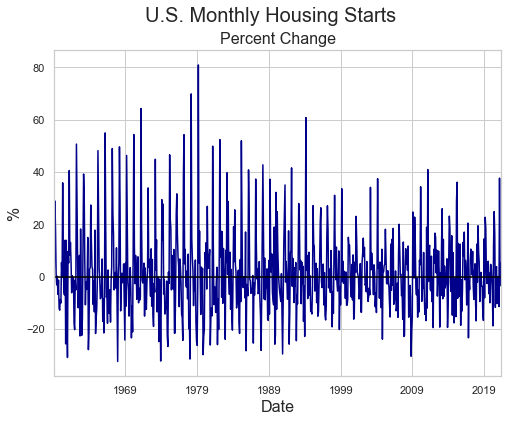

In [50]:
housing = fred.get_series("HOUSTNSA").asfreq('MS')
housing = housing.pct_change().dropna()

# Multiply by 100 
housing = 100 * housing

housing.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('U.S. Monthly Housing Starts', fontsize=20)
plt.title('Percent Change', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(0, color="black")

In [51]:
mod = AutoReg(housing, 1, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  748
Model:                     AutoReg(1)   Log Likelihood               -3108.826
Method:               Conditional MLE   S.D. of innovations             15.531
Date:                Wed, 23 Jun 2021   AIC                              5.494
Time:                        10:41:34   BIC                              5.512
Sample:                    03-01-1959   HQIC                             5.501
                         - 05-01-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9747      0.570      1.711      0.087      -0.142       2.092
y.L1           0.1877      0.036      5.222      0.000       0.117       0.258
                                    Roots           

In [52]:
res = mod.fit(cov_type="HC0")
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  748
Model:                     AutoReg(1)   Log Likelihood               -3108.826
Method:               Conditional MLE   S.D. of innovations             15.531
Date:                Wed, 23 Jun 2021   AIC                              5.494
Time:                        10:41:34   BIC                              5.512
Sample:                    03-01-1959   HQIC                             5.501
                         - 05-01-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9747      0.571      1.708      0.088      -0.144       2.093
y.L1           0.1877      0.032      5.848      0.000       0.125       0.251
                                    Roots           

In [53]:
sel = ar_select_order(housing, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  748
Model:                    AutoReg(13)   Log Likelihood               -2778.091
Method:               Conditional MLE   S.D. of innovations             10.599
Date:                Wed, 23 Jun 2021   AIC                              4.762
Time:                        10:41:34   BIC                              4.856
Sample:                    03-01-1960   HQIC                             4.799
                         - 05-01-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5184      0.463      3.282      0.001       0.612       2.425
y.L1          -0.2669      0.035     -7.573      0.000      -0.336      -0.198
y.L2          -0.0868      0.031     -2.772      0.0

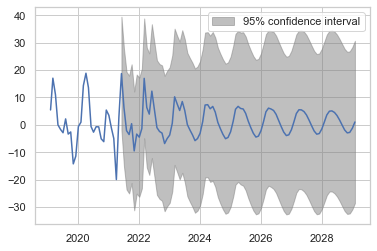

In [54]:
fig = res.plot_predict(720, 840)

## The ARIMA Using Simulated Data

In [55]:
np.random.seed(1066)
ar = np.array([.75, -.25])
ma = np.array([.65, .35])
ar = np.r_[1, -ar]
ma = np.r_[1, ma]
nobs = 500
y = arma_generate_sample(ar, ma, nobs)
dates = pd.date_range('1980-1-1', freq="M", periods=nobs)
y = pd.Series(y, index=dates) * 10

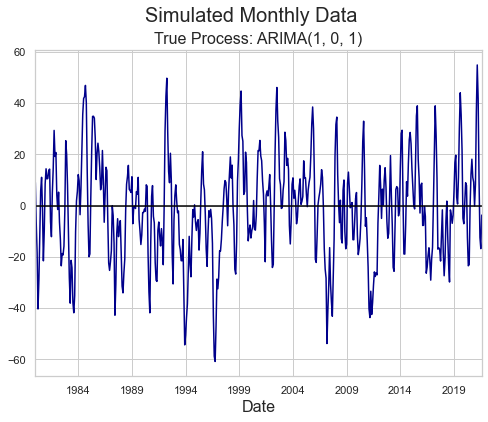

In [56]:
y.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Simulated Monthly Data', fontsize=20)
plt.title('True Process: ARIMA(1, 0, 1)', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.axhline(0, color="black")

In [57]:
arma_mod = ARIMA(y, order=(1, 0, 1), trend='n')
arma_res = arma_mod.fit()
print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1867.292
Date:                Wed, 23 Jun 2021   AIC                           3740.583
Time:                        10:41:35   BIC                           3753.227
Sample:                    01-31-1980   HQIC                          3745.545
                         - 08-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7108      0.036     19.727      0.000       0.640       0.781
ma.L1          0.4605      0.050      9.215      0.000       0.363       0.558
sigma2       102.3364      6.835     14.973      0.0

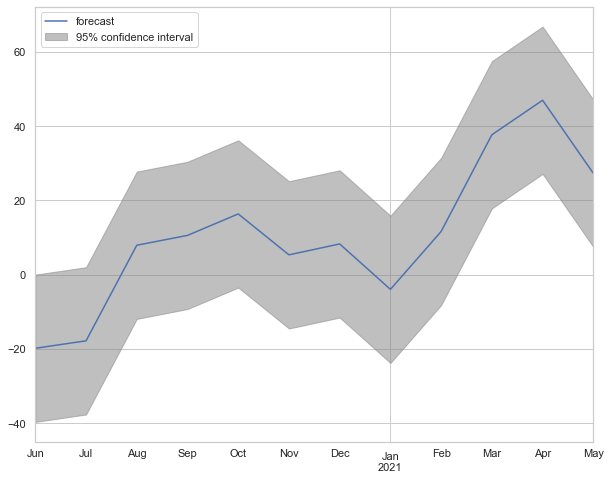

In [58]:
fig, ax = plt.subplots(figsize=(10,8))
fig = plot_predict(arma_res, start='2020-06-30', end='2021-05-31', ax=ax)
legend = ax.legend(loc='upper left')

#### Notes

* Autoregressive models are not *casual* explanations of how economic processes operate.
* Economic processes evolve very slowly, so historical relationships can be exploited to forecast.
* Such forecasts are subject to sudden shifts in economic activity, such as the GFC and COVID-19.
* For example, industrial absorption **increased** through the pandemic because Amazon **broke** the historical relationship between absorption and economic growth.
    * This arose from a secular shift toward e-commerce with the attendant need for warehouse space.
    * Remember, your domain knowledge is a key element of data analytics.  **USE IT.**

## Isolating Cycles from Trends in Time Series Data

* Occasionally, we do not need to do much to time series data than to disaggregate them into two components, a *systematic trend* and a *noisy cycle*.  
    * A typical example is seasonality: during particular periods of time *every* year, there is an increase in a time series that occurs on a regular cycle (such as, the sales of goods in the U.S. around the winter holidays).



* A popular algorithm to detrend data is the Hodrick-Prescott (HP) filter.  
    * Basically, the filter disaggregates a time series, $y_t$, into its trend component and its cyclical component.  
    * In some cases, our interest may lie in examining the trend rather than the noisy cycle.  



* Start with a time series, $y_t$, of size, $t=1,...,T$.  The Hodrick-Prescott filter disaggregates $y_t$ into a trend component, $\tau_t$, and a cyclical component, $\gamma_t$, such that $y_t = \tau_t + \gamma_t$.



* The components are determined by minimizing the following with respect to $\tau$:
    * ${\displaystyle \sum_{t = 1}^T {(y_t - \tau _t )^2 }  + \lambda \sum_{t = 2}^{T - 1} {[(\tau_{t+1}  - \tau_t) - (\tau_t  - \tau_{t - 1} )]^2 }}$



* The first term is the now-familiar squared error (or squared deviation), which measures deviations from the cyclical component, $\gamma_t$.  We seek to minimize this with respect to $\tau$, which is just our predictor.



* The second term arises from the fact that this algorithm uses constrained optimization (minimization, in this case), where the constraint is captured in the term associated with $\lambda$.  
    * Basically, $(\tau_{t+1} - \tau_t)$ is the rate of change in the trend at $t+1$, while $(\tau_{t} - \tau_{t-1})$ is the rate of change in the trend at $t$.  
    * The constraint imposed on the minimization problem penalizes large variations in the growth rates of the trend.
    * Rule of thumb: $\lambda = 1600$ for quarterly data (which is considered a baseline).  In practice, we adjust $\lambda$ in the following manner (see http://discovery.ucl.ac.uk/18641/1/18641.pdf):



1. $\lambda = 6.25$ for annual data.
2. $\lambda = 129600$ for monthly data.
3. $\lambda = 104976000000$ for daily data.

Text(0, 0.5, '$')

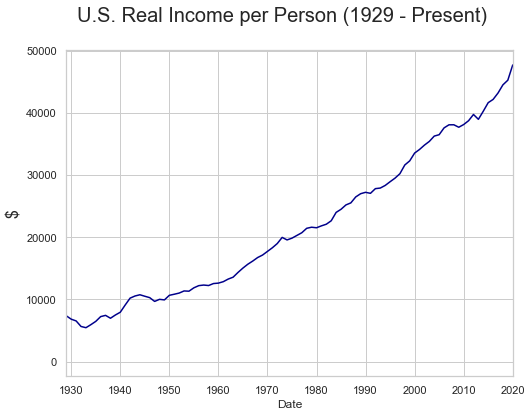

In [59]:
gdp_pc = fred.get_series('A229RX0A048NBEA')

gdp_pc.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('U.S. Real Income per Person (1929 - Present)', fontsize=20)
plt.ylabel('2009 US$', fontsize=16)
aapl.plot(color = 'darkblue', figsize=(8, 6))
plt.ylabel('$', fontsize=16)

In [60]:
# Decompose into cyclical and trend components.

cycle, trend = sma.tsa.filters.hpfilter(gdp_pc, lamb = 6.25)

Text(0, 0.5, '$')

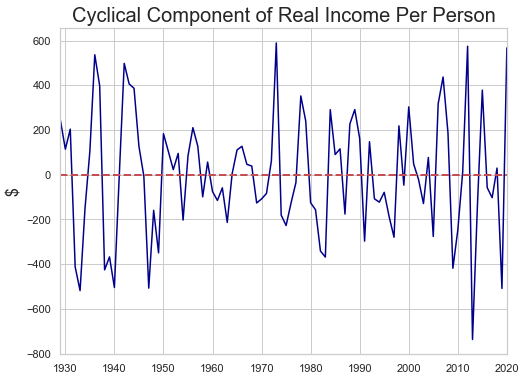

In [61]:
# Cyclical component

cycle.plot(color='darkblue', figsize=(8, 6))
plt.title('Cyclical Component of Real Income Per Person', fontsize=20)
plt.axhline(0, color='r', ls='--', lw=2)
plt.ylabel('$', fontsize=16)

Text(0, 0.5, '$')

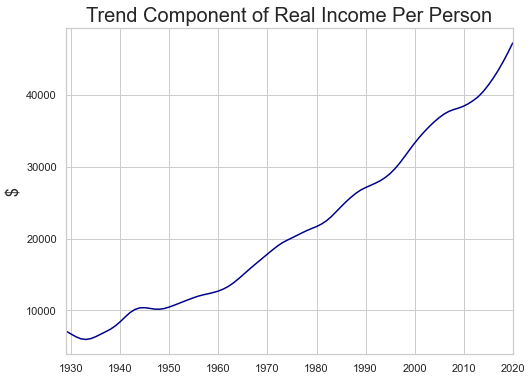

In [62]:
# Trend Component

trend.plot(color='darkblue', figsize=(8,6))
plt.title('Trend Component of Real Income Per Person', fontsize=20)
plt.ylabel('$', fontsize=16)